# Mapping sensor level measurements to source level brain activity

The SEEG data is modeled by $S(t)=GX(t)$, where $S \in\mathbb{R}^{ns \times nt}$ is sensor-level SEEG measurements at time $t$, and $G \in\mathbb{R}^{ns \times nn}$ is gain (lead-field or projection) matrix. The source brain activity $X \in\mathbb{R}^{nn \times nt}$ rendering as a non-linear function of hidden states given by Epileptor model. Here, we aim to estimate the hidden source brain activity $X(t)$ by Moore-Penrose inversion of the known gain matrix $G$, and compared it with two implementations of source estimation in Stan.

$nn$: number of brain regions,

$ns$: number of sensors, 

$nt$: number of data points per sensor.



In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from numpy.linalg import matrix_rank

In [4]:
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cwd = os.getcwd()
cwd

'/data/ProbabilisticSourceLocalization'

Here, we load the simulated data (TVB output).

In [6]:
synthetic_data=np.load(cwd+'/data_input_files/TVBsimulatedSEEG_Epileptor6D.npz')

In [7]:
G=synthetic_data['Gain']
X_true=synthetic_data['X_true']
Z_true=synthetic_data['Z_true']
Ez_idx=synthetic_data['Ez_idx']
Pz_idx=synthetic_data['Pz_idx']

In [8]:
G.shape, X_true.shape

((162, 84), (84, 1200))

In [9]:
Seeg=np.dot(G, X_true)
Seeg.shape

(162, 1200)

ns: total number of sensors

ns: total number of regions (nodes)

nt: total number of recording times


In [10]:
nt=int(Seeg.shape[1])
ns=int(G.shape[0])
nn=int(G.shape[1])

In [11]:
nn, ns, nt

(84, 162, 1200)

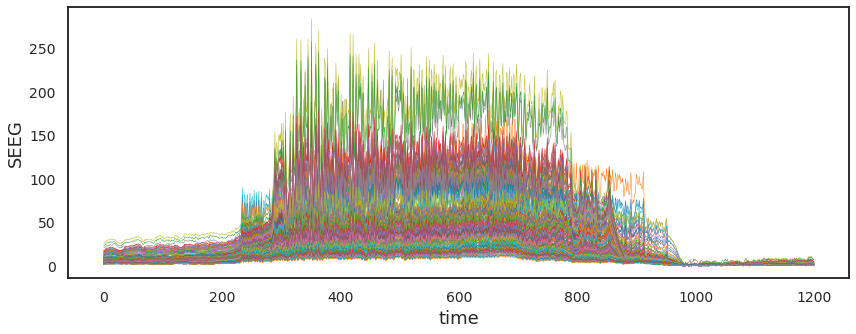

In [12]:
plt.figure(figsize=(14, 5))
for i in range(ns):
    plt.plot(Seeg[i, :]-min(Seeg[i, :]), lw=0.5)
plt.xlabel("time", fontsize=18)
plt.ylabel("SEEG", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd+'/Figs',"SimulatedSeeg.png"))
plt.show() 

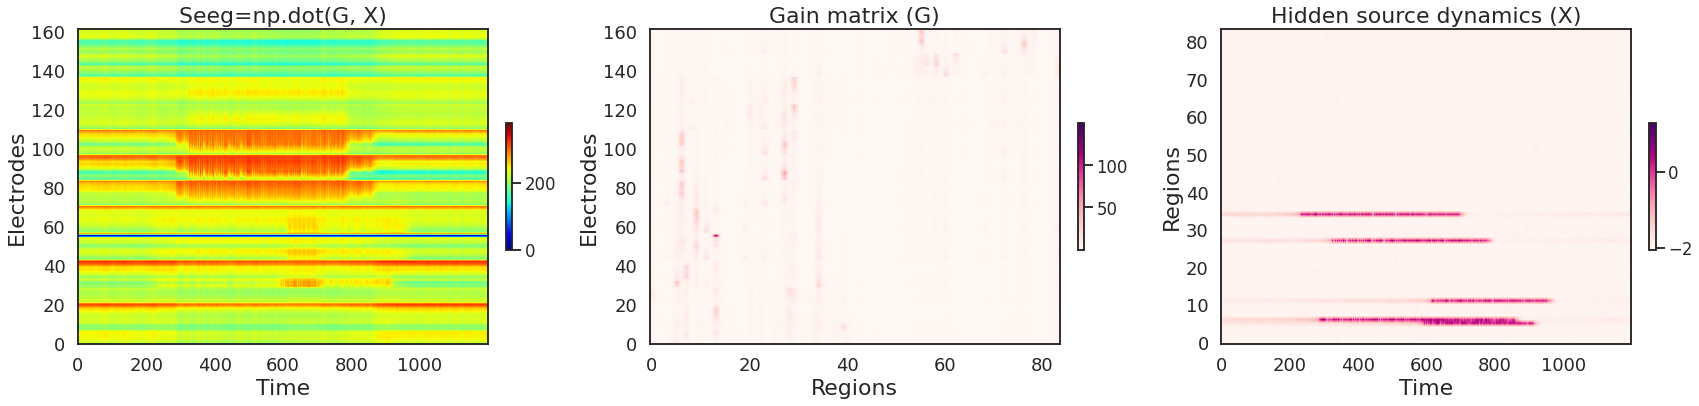

In [13]:
plt.figure(figsize=(24, 6))
plt.subplot(131);
plt.imshow(Seeg-np.min(Seeg, axis=0), aspect='auto', interpolation='bilinear',  origin='lower', cmap='jet')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.title("Seeg=np.dot(G, X)", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Electrodes', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(132);
plt.imshow(G, aspect='auto', interpolation='bilinear',  origin='lower', cmap='RdPu')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.title("Gain matrix (G)", fontsize=22) 
plt.xlabel('Regions', fontsize=22)
plt.ylabel('Electrodes', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(133);
plt.imshow(X_true, aspect='auto', interpolation='bilinear',  origin='lower', cmap='RdPu')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.title("Hidden source dynamics (X)", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Regions', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.tight_layout(pad=2)
plt.savefig(os.path.join(cwd+'/Figs',"SimulatedSeeg_G_sources.png"))
plt.show()

We can define the Moore-Penrose or generalized inversion (g-inverse) as follows:

Given a rectangular matrix G with dimention $ns\times nn$, matrix $G^{-}$ is said to be a generalized inverse (Moore-Penrose inverse) of $G$ if:  $GG^{-}G=G$. 

The generalized inverse is defined as the matrix $G^{-}$ such that

$GG^{-}G=G$ and $G^{-}GG^{-}=G^{-}$. 

Note that both $GG^{-}$ and $G^{-}G$ are symmetric, but neither product gives an identity matrix.

Given $S(t)=GX(t)$, where the rectangular matrix $S(t)$ with dimention $ns \times nt$ is sensor level measuremenets at time t, matrix $G$ with dimention $ns \times nn$ is the gain matrix, and $X(t)$ represents the unknown source brain activity at time t with dimention $nn \times nt$. To estimate $X(t)$, we need


$ (S-GX)^\top (S-GX) | \underset {\min_{x_1,\dots x_{nt}} \displaystyle} =0$, 

then setting the derivative to zero:

$\dfrac{d}{dX} ((S-GX)^\top (S-GX))=0$,

yields:


$X=(G^\top G)^{-} G^\top S$.


Here $(G^\top G)^{-}$ is g-inverse of $G^\top G$:

$QQ^{-}Q=Q$, where  $Q=G^\top G$.

Here $\top$ denotes the matrix transposition.

In [14]:
matrix_rank(G)

84

In [15]:
Q=np.dot(G.T, G)

In [16]:
Q.shape, matrix_rank(Q)

((84, 84), 74)

In [17]:
log(Q).max()

10.342591112093789

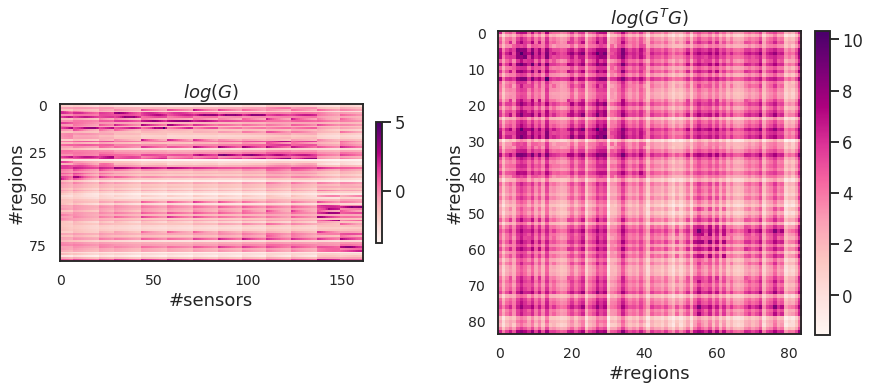

In [18]:
from matplotlib import colors, cm

plt.figure(figsize=(13,6))

plt.subplot(121)
plt.imshow(np.log(G.T),  interpolation='nearest', cmap='RdPu' )
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.4)
plt.xlabel("#sensors", fontsize=18)
plt.ylabel("#regions", fontsize=18)
plt.title("$log (G)$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(np.log(Q),  interpolation='nearest', cmap='RdPu' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel("#regions", fontsize=18)
plt.ylabel("#regions", fontsize=18)
plt.title("$log (G^TG)$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout(pad=4)
plt.savefig(os.path.join(cwd+'/Figs',"plot_GTG.png"))
plt.show()

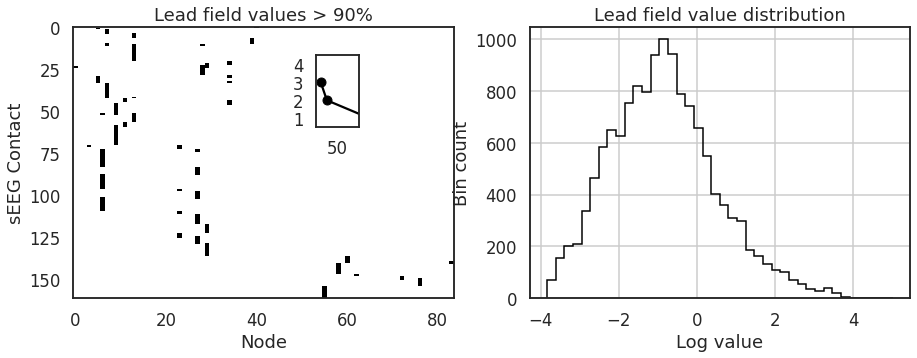

In [19]:
from matplotlib import rc
rc('image', cmap='binary', interpolation='nearest')

plt.figure(figsize=(15, 5))
plt.subplot(121)
nGr = G/G.max(axis=1)[:, newaxis] > 0.9
plt.imshow(nGr, interpolation='nearest', aspect='auto')
plt.title('Lead field values > 90%'), plt.xlabel('Node'), plt.ylabel('sEEG Contact')
a = axes([.35, .6, .04, .2])
n = bincount(nGr.sum(axis=1))
plt.plot(n[1:], np.r_[1:len(n)], 'ko-')
plt.yticks([1, 2, 3, 4]), plt.xticks([50]), plt.ylim([0.5, 4.5]), plt.xlim([-10, 110])
plt.subplot(122), plt.hist(log(G).reshape((-1,)), 40, color='k', histtype='step'), grid(1);
plt.title('Lead field value distribution'), plt.xlabel('Log value'), plt.ylabel('Bin count');

Although X(t) is driven by noise due to the stochastic formalization of Epileptor model (SDEs), here, we add observation noise to the measuremd SEEG data:

In [20]:
noise_level=0.01

In [21]:
S=Seeg+noise_level*np.random.randn(ns,nt)

In [22]:
S.shape, G.shape, X_true.shape

((162, 1200), (162, 84), (84, 1200))

Note that pseudo-inverse of matrix Q is sensitive to the level of tolerance, i.e., the cutoff for small singular values. Accordinng to numpy.linalg.pinv¶, the Singular values smaller (in modulus) than rcond * largest_singular_value (again, in modulus) are set to zero.

To get the proper tolerence value, we sweep over rcond using $np.linalg.pinv$, and we then select the min of error between $Q$ and $QQ^{-}Q$, where $Q=G^\top G$. 

In [23]:
tol=[]
Errinv=[]
sweep_range=range(30)

i=0
for e in sweep_range:
    eps=(10**(-e))
    Q_ginv = np.linalg.pinv(Q,  rcond=eps)
    tol.append(10**(-e))
    Errinv.append(np.sum((Q- np.dot(Q, np.dot(Q_ginv, Q)))**2))
    i=i=1

In [24]:
np.log(Errinv)[np.argmin(Errinv)]

-19.862845060898586

In [25]:
eps_opt = tol[np.argmin(Errinv)]
print('optimal rcond=', eps_opt)

optimal rcond= 1e-10


 The following figure shows the error between $Q=G^\top G$ and $QQ^{-}Q$, indicating that the pseudo-inverse of matrix $Q=G^\top G$ is very sensitive to the tolerance level, i.e., the cutoff for small singular values.

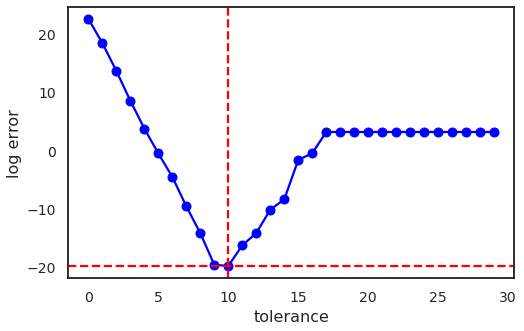

In [26]:
plt.figure(figsize=(8, 5))    
plt.plot(sweep_range, np.log(Errinv), '.b-', markersize=18)
plt.axvline(x=np.argmin(Errinv),color='red',linestyle='--')
plt.axhline(y=np.log(Errinv)[np.argmin(Errinv)],color='red',linestyle='--')
plt.xlabel("tolerance", fontsize=16)
plt.ylabel("log error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd+'/Figs',"SweepTolerence.png"))
plt.show()

In [27]:
Q_ginv = np.linalg.pinv(Q,  rcond=eps_opt)

In [28]:
np.allclose(Q, np.dot(Q, np.dot(Q_ginv, Q)))   

True

In [29]:
print('error=', np.sum((Q- np.dot(Q, np.dot(Q_ginv, Q))))**2)

error= 7.352173765965567e-08


 Here, the source signal was estimated as $X_{est}=(G^\top G)^{-} G^ \top S$, where  $(G^\top G)^{-}$ is g-inverse of $G^\top G$ ( i.e., with  $Q=G^\top G$, then: $QQ^{-}Q=Q$).

In [30]:
X_est_np_ginv=np.dot(np.dot(Q_ginv, G.T), S)

In [31]:
X_est_np_ginv.shape, X_true.shape

((84, 1200), (84, 1200))

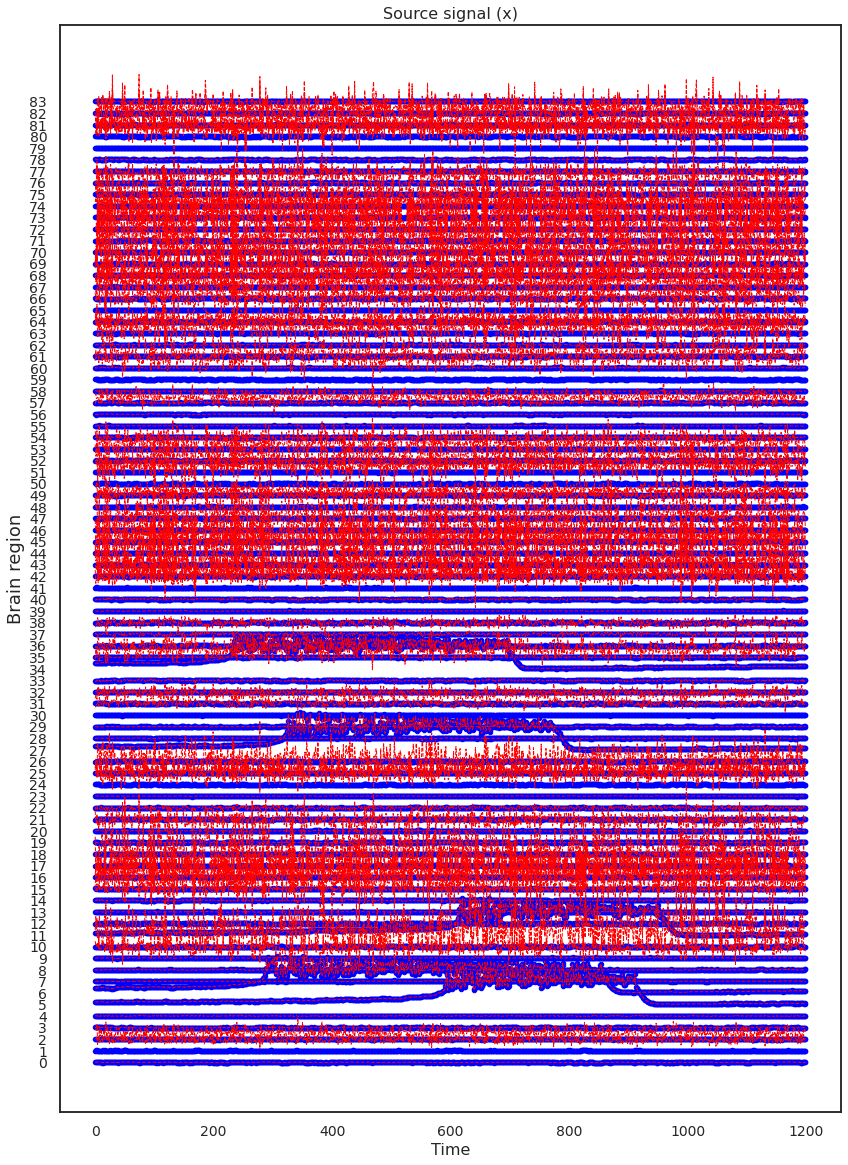

In [32]:
plt.figure(figsize=(14,20))
plt.plot(X_true.T+ np.r_[0:(nn)]+2, '.b')
plt.plot(X_est_np_ginv.T+ np.r_[0:(nn)]+2, 'r--', linewidth=1)
plt.yticks(np.r_[0:(nn)], np.r_[0:(nn)],fontsize=10)
plt.title("Source signal (x)",fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Brain region',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd+'/Figs',"EstimatedSourceSignals_ginv.png"))
plt.show()

In [33]:
ROI=np.array([Ez_idx[1], Pz_idx[2], 7, 50])
ROI

array([34, 27,  7, 50])

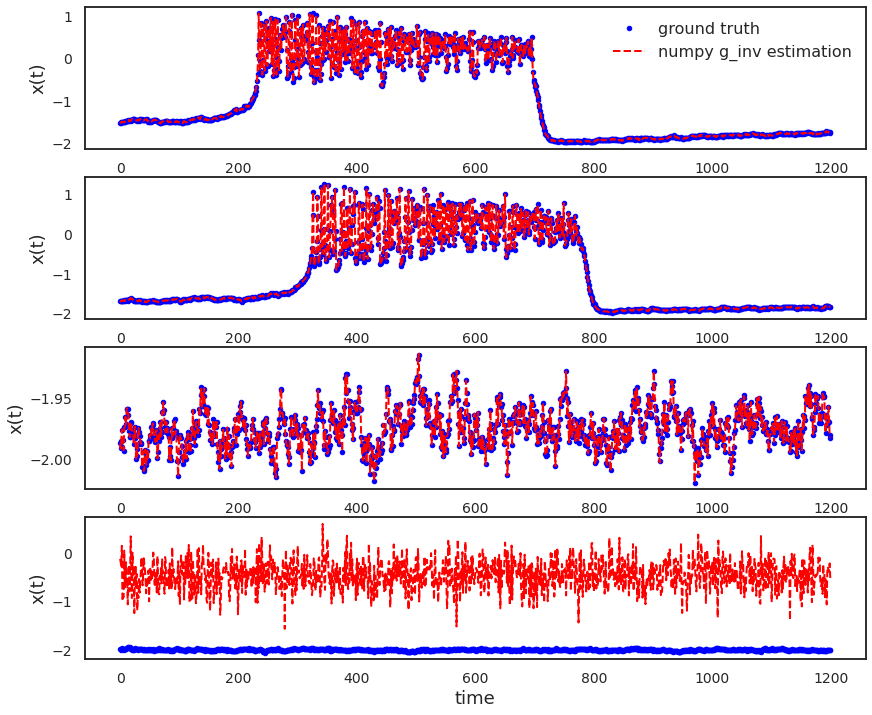

In [34]:
plt.figure(figsize=(14,12))

for i in range(len(ROI)):
    plt.subplot(len(ROI),1,i+1)
    plt.plot(X_true[ROI[i],], '.b', linewidth=1, label='ground truth', zorder=1)
    plt.plot(X_est_np_ginv[ROI[i],], 'r--', linewidth=2, label='numpy g_inv estimation', zorder=2)

    plt.ylabel('x(t)',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if i==0:
        plt.legend(fontsize=16, frameon=False, loc='upper right') 

    if i==(len(ROI)-1): 
        plt.xlabel('time',fontsize=18)
plt.show()

In [35]:
Err_per_region_np_ginv= np.sum((X_est_np_ginv-X_true)**2, axis=1)

In [36]:
print('error in source estimation=', np.sum(Err_per_region_np_ginv))

error in source estimation= 75454.0073384408


Note that error mainly concentrated on HZ on the right brain hemisphere where there is no electrode implantation (left focal epilepsy), i.e.,  where the gain matrix goes to zeros, equivalently,  ($G^{T}G$) is sparse.

In [37]:
print('error in source EZ estimation=', Err_per_region_np_ginv[Ez_idx])

error in source EZ estimation= [6.82636766e-05 2.04796091e-02]


In [38]:
print('error in source PZ estimation=', Err_per_region_np_ginv[Pz_idx])

error in source PZ estimation= [4.29783286e-04 5.97434621e-03 7.66930371e-05]


In [39]:
print('error in source HZ estimation=', Err_per_region_np_ginv[7])

error in source HZ estimation= 0.00026754777256141255


In [40]:
print('error in source HZ estimation=', Err_per_region_np_ginv[50])

error in source HZ estimation= 2927.9244981199145


In the following we show that the error in the estimation of hidden states are mainly related to the regions which are located far from the sensors (right hemisphere in left epilepsy patient.)

# Plot region and electrode positions

Here we load the electrode "contacts" from "complex.ades"

In [41]:
contacts = []
with open(cwd+ '/ExperimentalData/PatientData/complex_raw.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx)) 

Here we assigne the names, and xyz positions of regions and the electrodes from "centers.txt", "elecs_name.txt", respectively, and then we plot them in (x, y),  (x,z), and (y,z) coordinates.

In [42]:
reg_xyz = np.loadtxt(cwd+ '/ExperimentalData/PatientData/centers.txt', usecols=(1,2,3))
reg_names = []
with open(cwd+ '/ExperimentalData/PatientData/centers.txt', 'r') as fd:
    for i, line in enumerate(fd.readlines()):
        reg_names.append('r%03d-%s' % (i, line.strip().split()[0]))


seeg_labels = []
seeg_xyz = np.loadtxt(cwd+ '/ExperimentalData/PatientData/elecs_name.txt', usecols=(1,2,3))
with open(cwd+ '/ExperimentalData/PatientData/elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = np.array([seeg_xyz[i] for i in monopolar_chan_to_pos])

In [43]:
def plot_electrodes():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(sa, sb ,color='gray',marker='^', s=25)
        yy=Err_per_region_np_ginv
        colors = cm.seismic(yy)
        plt.scatter(ra,rb, cmap = 'rainbow', color=colors, s=50)
        plt.scatter(ra,rb, color=colors, s=.5e-2+0.05*yy)
        plt.axis([-120, 100, -120, 100])

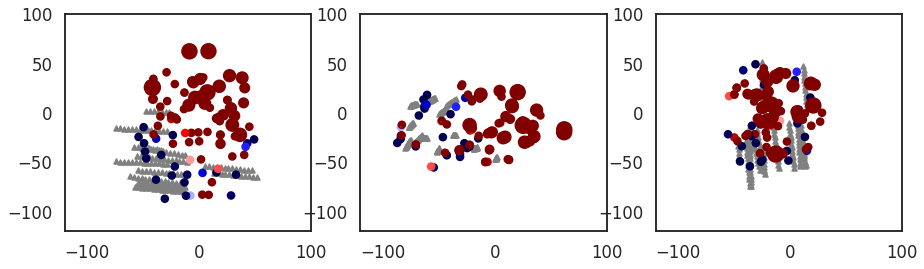

In [44]:
plt.figure(figsize=(15, 4))
plot_electrodes()
plt.savefig(os.path.join(cwd+'/Figs',"SensorSourcepng"))
plt.show()

In [45]:
elecnames=[]
electrodes = {}  
with open(cwd+ '/ExperimentalData/PatientData/elecs_name.txt', 'r') as fd:
            for i, line in enumerate(fd.readlines()):
                line = line.strip()
                contact, x, y, z = line.split()
                elecnames.append(contact)
                name, _ = re.match("([A-Za-z]+[']*)([0-9]+)", contact).groups()
                if name in electrodes:
                    electrodes[name].append(i)
                else:
                    electrodes[name] = [i]

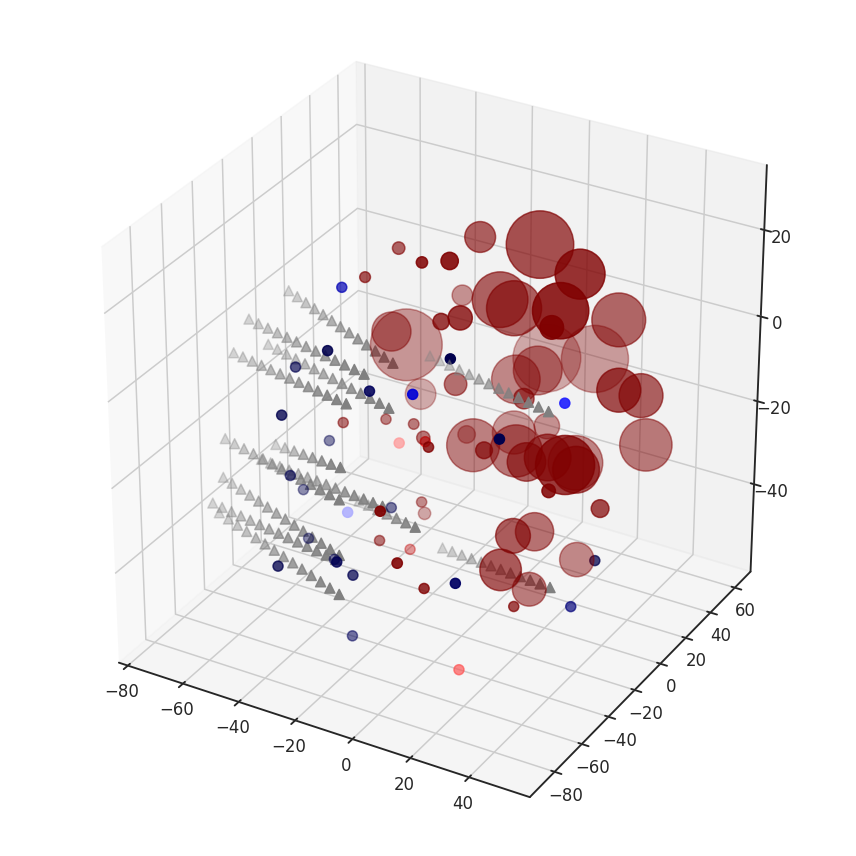

In [46]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for name, idxs in electrodes.items():
    ax.scatter(seeg_xyz [idxs, 0], seeg_xyz [idxs, 1], seeg_xyz [idxs, 2], color='grey', marker='^', s=100)
    
y=Err_per_region_np_ginv
colors = cm.seismic(y)
ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color=colors, s=100+y)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"SourceLocalizationErrorperRegion.png"))
plt.show()    

### Save data input to run HMC

In [47]:
Seeg.shape, G.shape, X_true.shape

((162, 1200), (162, 84), (84, 1200))

In [48]:
ns, nn, nt

(162, 84, 1200)

In [49]:
from lib.Rdump import stan_rdump

In [50]:
data_iput_filename=str('datainput_SourceEstimation_SEEG_Epileptor6D')

In [51]:
1

1

In [52]:
1

1

In [51]:
data_iput_dict= {
    'nn': int(nn),  'nt': int(nt), 'ns': ns,
    'Seeg': S.T, 'Gain': G, 'X_true': X_true,
}

In [52]:
nd=[]
npz = {'nd': nd}
npz.update(data_iput_dict)
np.savez(cwd+'/data_input_files/'+ str(data_iput_filename) +'.R.npz', **npz)
np.savez(cwd+'/data_input_files/'+ str(data_iput_filename) +'.npz', **npz)
stan_rdump(data_iput_dict, cwd+'/data_input_files/' + str(data_iput_filename)+ '.R')

#### Here, we first perform the above pseudoinverse in Stan using inverse_spd.

In [53]:
! cat SEEG_SourceEstimation_ginv.stan

data {
  int nt;
  int nn;
  int ns;

  matrix[nt, ns] Seeg;
  matrix[ns, nn] Gain;
}

transformed data {
  matrix[nn, nn] Q_inv;
  vector[nt*ns] Seeg_obs_vect;

  Q_inv=inverse_spd(Gain'*Gain);
  Seeg_obs_vect=to_vector(Seeg);

}

parameters {
  real<lower=0.0> eps; 
}

transformed parameters {
  matrix[nn, nt] X_est;
  X_est=Q_inv*Gain'*Seeg';

}

model {
  matrix[nt, ns] Seeg_model;
  vector[nt*ns]  Seeg_model_vect;

  eps ~ normal(0.,1.);


  for(t in 1:nt){
    Seeg_model[t,]=to_row_vector((Gain*X_est[,t]));
  }

  Seeg_model_vect=to_vector(Seeg_model);

  for(i in 1:(nt*ns)){
    target+=  normal_lpdf(Seeg_obs_vect[i]| Seeg_model_vect[i], eps);  
  }

}


generated quantities {     
}


In [54]:
model=str('SEEG_SourceEstimation_ginv')

In [55]:
curr_dir=cwd

In [56]:
! cd /home/meysam/cmdstan-2.28.2 && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  --o=/data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_ginv.hpp /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_ginv.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_5.7.0/include    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_ginv.o /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_ginv.hpp
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan

In [57]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=200
warm_iter=200

model=SEEG_SourceEstimation_ginv
data_input=datainput_SourceEstimation_SEEG_Epileptor6D.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 1`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [58]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [59]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/ProbabilisticSourceLocalization/data_output_hmc_SEEG_SourceEstimation_ginv'

In [60]:
! ls $dir_data_output

output_hmc_SEEG_SourceEstimation_ginv_1.csv
output_hmc_SEEG_SourceEstimation_ginv_1.out


In [61]:
!tail -n2 $dir_data_output/*$model*out

               85.354 seconds (Total)



## check the convergence 

In [62]:
chain=1

In [63]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_SEEG_SourceEstimation_ginv_1.csv'

In [64]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.csv'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [65]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

Iteration: 400 / 400 [100%]  (Sampling)
  Elapsed Time: 43.114 seconds (Warm-up)
                42.24 seconds (Sampling)
                85.354 seconds (Total)



In [66]:
from lib.report_algconfigs import hmc_config
num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

In [67]:
num_samples=int(num_samples)

In [68]:
if int(save_warmup)==0:
    Burnin=0
nSample=num_samples-Burnin

## posterior predictive density 

In [69]:
from lib.parse_csv import parse_csv2

In [70]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [71]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (200,)
accept_stat__ (200,)
stepsize__ (200,)
treedepth__ (200,)
n_leapfrog__ (200,)
divergent__ (200,)
energy__ (200,)
eps (200,)
X_est (200, 1200, 84)


In [72]:
X_hmc_ginv=fit['X_est'][-nSample:]
eps_hmc_ginv=fit['eps'][-nSample:]

In [73]:
X_est_hmc_ginv=np.mean(X_hmc_ginv, axis=0).T

In [74]:
eps_hmc_ginv.mean()

0.11440869499999998

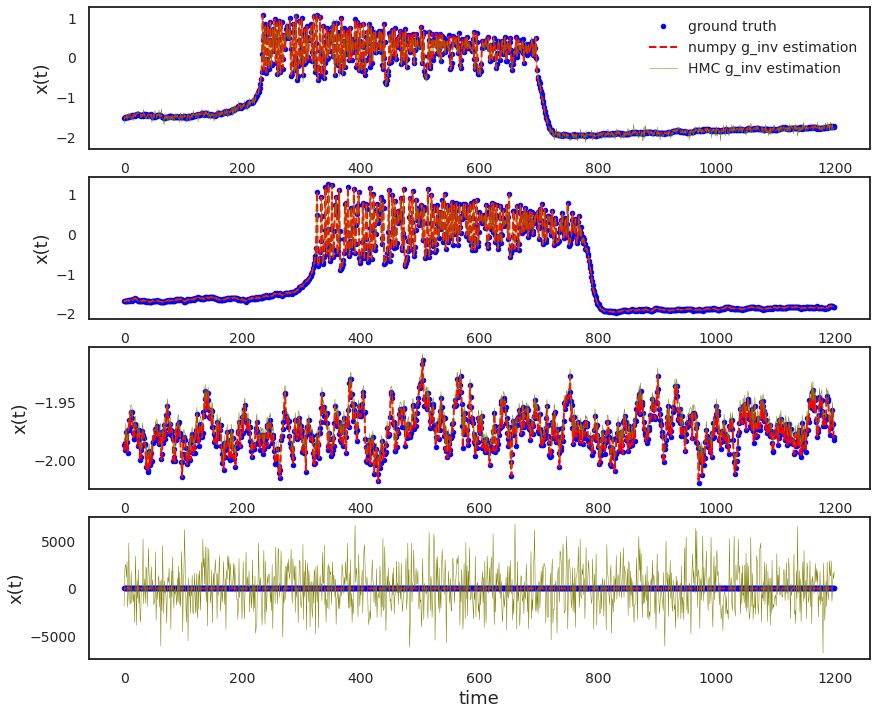

In [75]:
plt.figure(figsize=(14,12))

for i in range(len(ROI)):
    plt.subplot(len(ROI),1,i+1)
    plt.plot(X_true[ROI[i],], '.b', linewidth=1, label='ground truth', zorder=1)
    plt.plot(X_est_np_ginv[ROI[i],], 'r--', linewidth=2, label='numpy g_inv estimation', zorder=2)
    plt.plot(X_est_hmc_ginv[ROI[i],], 'olive', linewidth=.5, label='HMC g_inv estimation', zorder=3)

    plt.ylabel('x(t)',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if i==0:
        plt.legend(fontsize=14, frameon=False, loc='upper right') 

    if i==(len(ROI)-1): 
        plt.xlabel('time',fontsize=18)
plt.show()

In [76]:
Err_per_region_hmc_ginv= np.sum((X_est_hmc_ginv-X_true)**2, axis=1)

In [77]:
print('error in source estimation by HMC ginv=', np.sum(Err_per_region_hmc_ginv))

error in source estimation by HMC ginv= 452199986222.4629


In [78]:
print('error in source EZ estimation by HMC ginv=', Err_per_region_hmc_ginv[Ez_idx])

error in source EZ estimation by HMC ginv= [1.31334271e-03 6.02241233e+00]


In [79]:
print('error in source PZ estimation by HMC ginv=', Err_per_region_hmc_ginv[Pz_idx])

error in source PZ estimation by HMC ginv= [0.04354457 0.16951943 0.00346441]


In [80]:
print('error in source HZ close to electrodes by HMC ginv=', Err_per_region_hmc_ginv[7])

error in source HZ close to electrodes by HMC ginv= 0.04696345163295634


In [81]:
print('error in source HZ far from electrodes by HMC ginv=', Err_per_region_hmc_ginv[50])

error in source HZ far from electrodes by HMC ginv= 6144621002.5244255


As you can see there is much larger error using ginv in Stan due to not choosing proper hyperparaeters compared to ginv with numpy. Due to such large error, we exclude that from comparision.

####  Now we use Stan to estimate $X(t)$ from $SEEG(t) \sim N (GX(t), \epsilon)$. 
We first use "to_vector" for implementation, then "row_vector", also with placing prior on hidden states, which lead to two orders of magnitude speed and also making the estimation error less than g-inv method by shifting the non-identifiable sources towards the desired values.

In [82]:
! cat SEEG_SourceEstimation_tovector.stan

data {
  int nt;
  int nn;
  int ns;

  matrix[nt, ns] Seeg;
  matrix[ns, nn] Gain;
}

transformed data {
  vector[nt*ns] Seeg_obs_vect;
  Seeg_obs_vect=to_vector(Seeg);
}

parameters {
  matrix[nn, nt] X_est;
  real<lower=0.0> eps; 
}

transformed parameters {
}

model {
  matrix[nt, ns] Seeg_model;
  vector[nt*ns]  Seeg_model_vect;

  eps ~ normal(0.,1.);

  for(t in 1:nt){
    Seeg_model[t,]=to_row_vector((Gain*X_est[,t]));
  }

  Seeg_model_vect=to_vector(Seeg_model);

  for(i in 1:(nt*ns)){
    target+=  normal_lpdf(Seeg_obs_vect[i]| Seeg_model_vect[i], eps);  
  }

}


generated quantities {      
}


In [83]:
model=str('SEEG_SourceEstimation_tovector')

In [84]:
curr_dir=cwd

In [85]:
! cd /home/meysam/cmdstan-2.28.2 && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  --o=/data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_tovector.hpp /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_tovector.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_5.7.0/include    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_tovector.o /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_tovector.hpp
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI1

In [86]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=200
warm_iter=200

model=SEEG_SourceEstimation_tovector
data_input=datainput_SourceEstimation_SEEG_Epileptor6D.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 1`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [87]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [88]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/ProbabilisticSourceLocalization/data_output_hmc_SEEG_SourceEstimation_tovector'

In [89]:
! ls $dir_data_output

output_hmc_SEEG_SourceEstimation_tovector_1.csv
output_hmc_SEEG_SourceEstimation_tovector_1.out


In [90]:
!tail -n2 $dir_data_output/*$model*out

               14277.9 seconds (Total)



## check the convergence 

In [91]:
chain=1

In [92]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_SEEG_SourceEstimation_tovector_1.csv'

In [93]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.csv'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [94]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

Iteration: 400 / 400 [100%]  (Sampling)
  Elapsed Time: 6405.79 seconds (Warm-up)
                7872.14 seconds (Sampling)
                14277.9 seconds (Total)



In [95]:
from lib.report_algconfigs import hmc_config
num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

In [96]:
num_samples=int(num_samples)

In [97]:
if int(save_warmup)==0:
    Burnin=0
nSample=num_samples-Burnin

## posterior predictive density 

In [98]:
from lib.parse_csv import parse_csv2

In [99]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [100]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (200,)
accept_stat__ (200,)
stepsize__ (200,)
treedepth__ (200,)
n_leapfrog__ (200,)
divergent__ (200,)
energy__ (200,)
X_est (200, 1200, 84)
eps (200,)


In [101]:
X_hmc_noprior=fit['X_est'][-nSample:]
eps_hmc_noprior=fit['eps'][-nSample:]

In [102]:
X_hmc_noprior.shape

(200, 1200, 84)

In [103]:
eps_hmc_noprior.mean()

0.029702403500000002

In [104]:
X_est_hmc_noprior=np.mean(X_hmc_noprior, axis=0).T

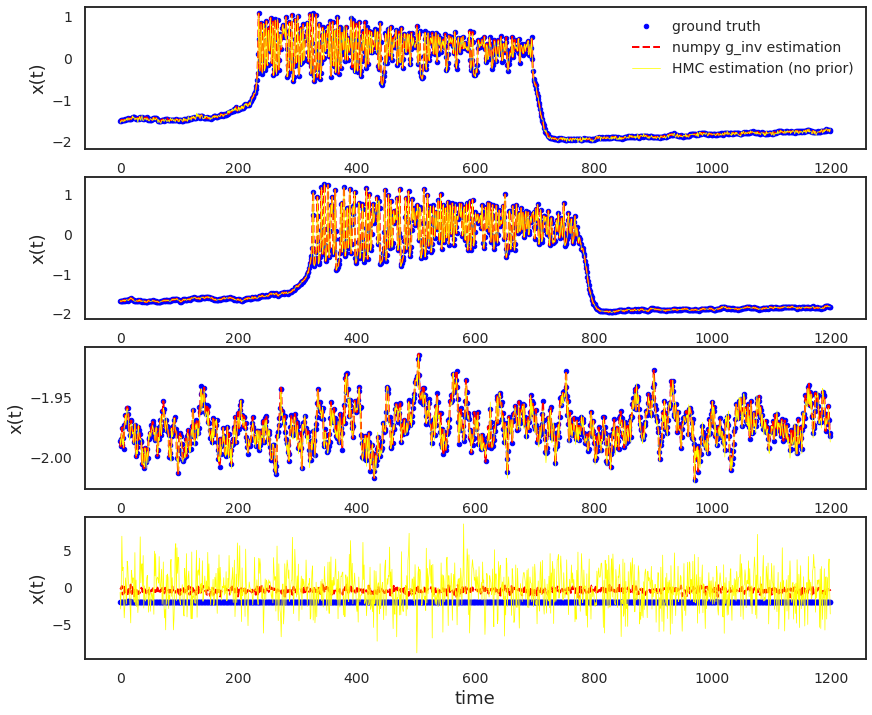

In [105]:
plt.figure(figsize=(14,12))

for i in range(len(ROI)):
    plt.subplot(len(ROI),1,i+1)
    plt.plot(X_true[ROI[i],], '.b', linewidth=1, label='ground truth', zorder=1)
    plt.plot(X_est_np_ginv[ROI[i],], 'r--', linewidth=2, label='numpy g_inv estimation', zorder=2)
    plt.plot(X_est_hmc_noprior[ROI[i],], 'yellow', linewidth=.75, label='HMC estimation (no prior)', zorder=3)

    plt.ylabel('x(t)',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if i==0:
        plt.legend(fontsize=14, frameon=False, loc='upper right') 

    if i==(len(ROI)-1): 
        plt.xlabel('time',fontsize=18)
plt.show()

In [106]:
Err_per_region_hmc_noprior= np.sum((X_est_hmc_noprior-X_true)**2, axis=1)

In [107]:
print('error in source estimation by HMC no prior=', np.sum(Err_per_region_hmc_noprior))

error in source estimation by HMC no prior= 325575.5860677821


In [108]:
print('error in source EZ estimation by HMC no prior=', Err_per_region_hmc_noprior[Ez_idx])

error in source EZ estimation by HMC no prior= [0.00124414 0.82614571]


In [109]:
print('error in source PZ estimation by HMC no prio=', Err_per_region_hmc_noprior[Pz_idx])

error in source PZ estimation by HMC no prio= [0.00303231 0.22359913 0.00236831]


In [110]:
print('error in source HZ close to electrodes by HMC no prio=', Err_per_region_hmc_noprior[7])

error in source HZ close to electrodes by HMC no prio= 0.009785631651430426


In [111]:
print('error in source HZ far from electrodes by HMC no prio=', Err_per_region_hmc_noprior[50])

error in source HZ far from electrodes by HMC no prio= 11450.72419049266


Now we use rowvector and prior on hidden states.

In [112]:
! cat SEEG_SourceEstimation_rowvector.stan

data {
  int nt;
  int nn;
  int ns;

  row_vector[ns] Seeg[nt]; 
  matrix[ns, nn] Gain;
}

transformed data {
}

parameters {
  row_vector[nn] X_est[nt];
  real<lower=0.0> eps; 
}

transformed parameters {
}

model {
  row_vector[ns] Seeg_model[nt];

  for(i in 1:nn){
      X_est[:,i] ~ normal(-2.1,.5);
  }

  eps ~ normal(0.,1.);

  for(t in 1:nt){
   Seeg_model[t] = (Gain * (X_est[t,]'))' ;
  }

  for (t in 1:nt) {
    target += normal_lpdf(Seeg[t] | Seeg_model[t], eps);
  }

}


generated quantities {      
}


In [113]:
model=str('SEEG_SourceEstimation_rowvector')

In [114]:
curr_dir=cwd

In [115]:
! cd /home/meysam/cmdstan-2.28.2 && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  --o=/data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_rowvector.hpp /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_rowvector.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_5.7.0/include    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_rowvector.o /data/ProbabilisticSourceLocalization/SEEG_SourceEstimation_rowvector.hpp
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/

In [116]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=200
warm_iter=200

model=SEEG_SourceEstimation_rowvector
data_input=datainput_SourceEstimation_SEEG_Epileptor6D.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 1`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [117]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [118]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/ProbabilisticSourceLocalization/data_output_hmc_SEEG_SourceEstimation_rowvector'

In [119]:
! ls $dir_data_output

output_hmc_SEEG_SourceEstimation_rowvector_1.csv
output_hmc_SEEG_SourceEstimation_rowvector_1.out


In [120]:
!tail -n2 $dir_data_output/*$model*out

               6822.07 seconds (Total)



## check the convergence 

In [121]:
chain=1

In [122]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_SEEG_SourceEstimation_rowvector_1.csv'

In [123]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.csv'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [124]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

Iteration: 400 / 400 [100%]  (Sampling)
  Elapsed Time: 3145.91 seconds (Warm-up)
                3676.16 seconds (Sampling)
                6822.07 seconds (Total)



In [125]:
from lib.report_algconfigs import hmc_config
num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

In [126]:
num_samples=int(num_samples)

In [127]:
if int(save_warmup)==0:
    Burnin=0
nSample=num_samples-Burnin

## posterior predictive density 

In [128]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [129]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (200,)
accept_stat__ (200,)
stepsize__ (200,)
treedepth__ (200,)
n_leapfrog__ (200,)
divergent__ (200,)
energy__ (200,)
X_est (200, 84, 1200)
eps (200,)


In [130]:
X_hmc_withprior=fit['X_est'][-nSample:]
eps_hmc_withprior=fit['eps'][-nSample:]

In [131]:
X_hmc_withprior.shape

(200, 84, 1200)

In [132]:
eps_hmc_withprior.mean()

0.012422903

In [133]:
X_est_hmc_withprior=np.mean(X_hmc_withprior, axis=0)

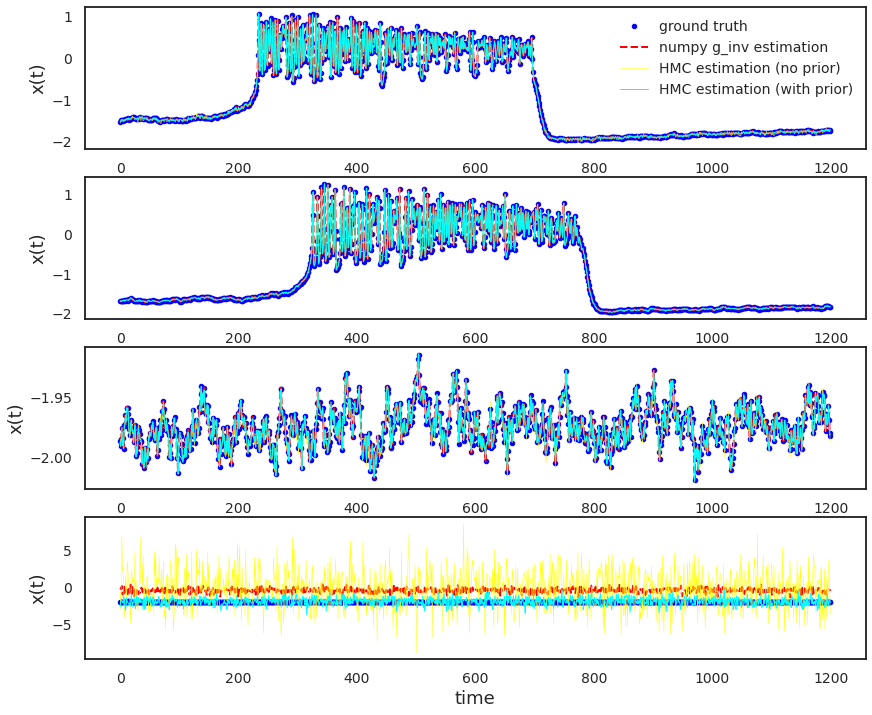

In [134]:
plt.figure(figsize=(14,12))

for i in range(len(ROI)):
    plt.subplot(len(ROI),1,i+1)
    plt.plot(X_true[ROI[i],], '.b', linewidth=1, label='ground truth', zorder=1)
    plt.plot(X_est_np_ginv[ROI[i],], 'r--', linewidth=2, label='numpy g_inv estimation', zorder=2)
    plt.plot(X_est_hmc_noprior[ROI[i],], 'yellow', linewidth=.5, label='HMC estimation (no prior)', zorder=4)
    plt.plot(X_est_hmc_withprior[ROI[i],], 'cyan', linewidth=1, label='HMC estimation (with prior)', zorder=5)

    plt.ylabel('x(t)',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if i==0:
        plt.legend(fontsize=14, frameon=False, loc='upper right') 

    if i==(len(ROI)-1): 
        plt.xlabel('time',fontsize=18)
plt.show()

In [135]:
Err_per_region_hmc_withprior= np.sum((X_est_hmc_withprior-X_true)**2, axis=1)

In [136]:
print('error in source estimation by HMC with prior=', np.sum(Err_per_region_hmc_withprior))

error in source estimation by HMC with prior= 10650.507805928193


In [137]:
print('error in source EZ estimation by HMC with prior=', Err_per_region_hmc_withprior[Ez_idx])

error in source EZ estimation by HMC with prior= [0.00013481 0.08317054]


In [138]:
print('error in source PZ estimation by HMC no prio=', Err_per_region_hmc_noprior[Pz_idx])

error in source PZ estimation by HMC no prio= [0.00303231 0.22359913 0.00236831]


In [139]:
print('error in source HZ close to electrodes by HMC with prio=', Err_per_region_hmc_withprior[7])

error in source HZ close to electrodes by HMC with prio= 0.0007707460340758432


In [140]:
print('error in source HZ far from electrodes by HMC with prio=', Err_per_region_hmc_withprior[50])

error in source HZ far from electrodes by HMC with prio= 309.83385647059345


### Comparison of the algorithms

In [141]:
model_list = ['np_ginv', 'hmc_noprior', 'hmc_withprior']


err_models_list = ["Err_per_region_{:s}".format(i) for i in model_list]

In [142]:
error_models=[np.sum(eval((err_models_list[i])))  for i in range(len(model_list))]

In [143]:
error_models_ez=[np.sum(Err_per_region_np_ginv[Ez_idx]),  np.sum(Err_per_region_hmc_noprior[Ez_idx]), np.sum(Err_per_region_hmc_withprior[Ez_idx])]

In [144]:
error_models_hz=[np.sum(Err_per_region_np_ginv[50]), np.sum(Err_per_region_hmc_noprior[50]), np.sum(Err_per_region_hmc_withprior[50])]

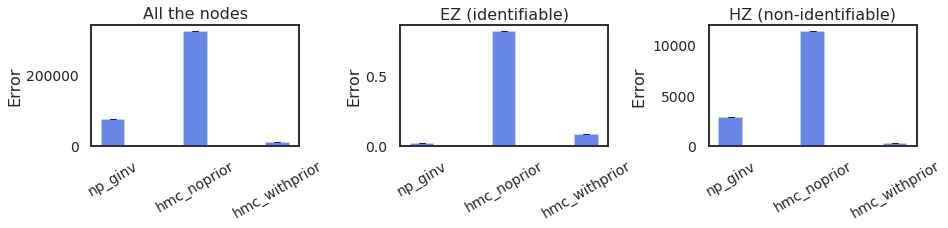

In [145]:
fig=figure(figsize=(13, 3))

error_kw= dict(ecolor='b', capsize=3, elinewidth=3)

ax1=subplot(131)
y=error_models
plt.bar(range(len(y)), y, yerr=0., width=0.3 ,color='royalblue', alpha=0.8, error_kw=error_kw)
plt.xticks(r_[:len(y)], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
plt.ylabel("Error", fontsize=16)
plt.title("All the nodes", fontsize=16)


ax2=subplot(132)
y=error_models_ez
plt.bar(range(len(y)), y, yerr=0., width=0.3 ,color='royalblue', alpha=0.8, error_kw=error_kw)
plt.xticks(r_[:len(y)], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
plt.ylabel("Error", fontsize=16)
plt.title("EZ (identifiable)", fontsize=16)

ax3=subplot(133)
y=error_models_hz
plt.bar(range(len(y)), y, yerr=0., width=0.3 ,color='royalblue', alpha=0.8, error_kw=error_kw)
plt.xticks(r_[:len(y)], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
plt.ylabel("Error ", fontsize=16)
plt.title("HZ (non-identifiable)", fontsize=16)

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(cwd+'/Figs',"AlgorithmicComparision.png"))
plt.show()

For above estimation the \hat R will be larger than 1.1, despite the accurate estimation, which is due to the non-identifiability in HZ. This needs to be investigated by reparameterization e.g., non-centered X_est. We can run Stan with optimization MAP, which is much more faster than HMC, but it can fail for mant run without initialization.